## PCAM dataset
https://github.com/basveeling/pcam  
PCAM is a dataset which is a small set of CAMELYON and going to make it as easy as MNIST/CIFAR10

In [1]:
import sys
sys.path.append("..")

In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from time import time

from glob import glob
from pathlib import Path

In [3]:
from src.utils import load_image_targets, show_example_images

## Load and check files

In [4]:
data_root = "../data/"
files = glob("{}/*[x|y].h5".format(data_root))

filepath = defaultdict(dict)
for i in files:
    file_ = Path(i).stem
    condition = re.findall(pattern="train|valid|test", string=file_)[0]
    target_type = re.findall(pattern="_[x|y]", string=file_)[0]
    
    filepath[condition][target_type] = i

In [5]:
# t1 = time()
# train_x, train_y = load_image_targets(
#     filepath["train"]["_x"],
#     filepath["train"]["_y"]
# )
# t2 = time()
# print("Elapse Time: {:.3f}".format(t2-t1))
## ~ 117 secs

# t1 = time()
# valid_x, valid_y = load_image_targets(
#     filepath["valid"]["_x"], 
#     filepath["valid"]["_y"]
# )
# t2 = time()
# print("Elapse Time: {:.3f}".format(t2-t1))
## ~ 14 secs

In [6]:
## ONLY FOR COURSE DEMO
from sklearn.model_selection import train_test_split

t1 = time()
train_x, train_y = load_image_targets(
    filepath["valid"]["_x"],
    filepath["valid"]["_y"]
)
t2 = time()
print("Elapse Time: {:.3f}".format(t2-t1))
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1)

t1 = time()
test_x, test_y = load_image_targets(
    filepath["test"]["_x"], 
    filepath["test"]["_y"]
)
t2 = time()
print("Elapse Time: {:.3f}".format(t2-t1))

Elapse Time: 14.683
Elapse Time: 17.903


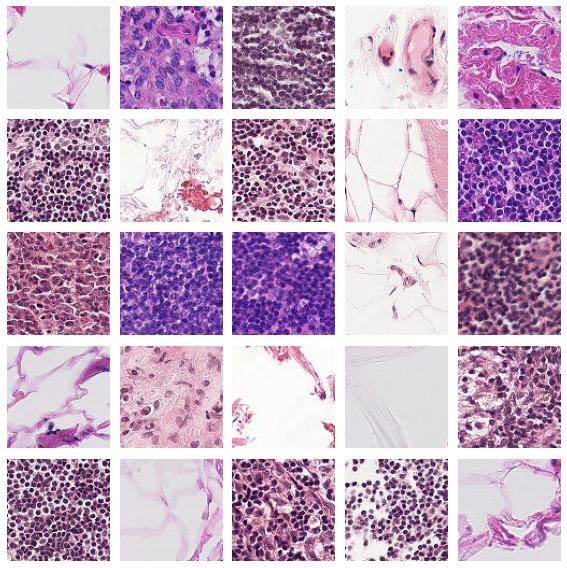

In [7]:
N = 5
index_0 = np.random.choice(np.where(train_y==0)[0], N**2)
examples_0 = np.take(train_x, index_0, axis=0)
show_example_images(examples_0, n_grid_x=N)

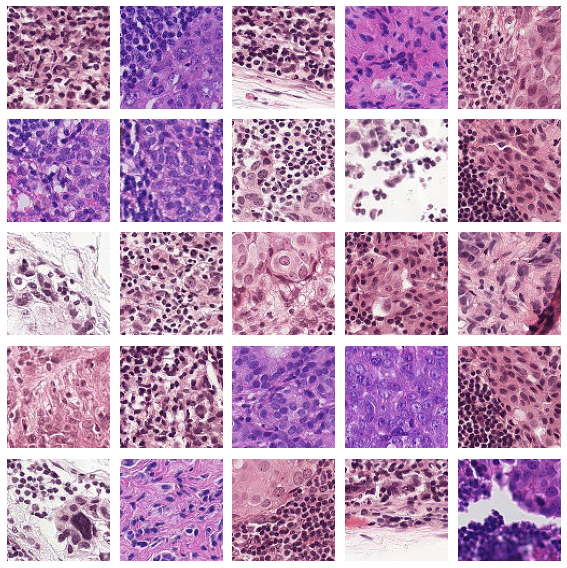

In [8]:
N = 5
index_1 = np.random.choice(np.where(train_y==1)[0], N**2)
examples_1 = np.take(train_x, index_1, axis=0)
show_example_images(examples_1, n_grid_x=N)

## Train classifier - Direct
* Logistic
* XGBoost

In [9]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from src.utils import get_result_metrics

In [10]:
# Vectorize images
train_x_vector = train_x.reshape((len(train_x), -1))
valid_x_vector = valid_x.reshape((len(valid_x), -1))
test_x_vector = test_x.reshape((len(test_x), -1))

print(train_x_vector.shape)

# Simple Normalize
train_x_vector = np.float32(train_x_vector) / 255.
valid_x_vector = np.float32(valid_x_vector) / 255.
test_x_vector = np.float32(test_x_vector) / 255.

(29491, 27648)


In [11]:
model_logistic = LogisticRegression().fit(train_x_vector, train_y)
y_pred = model_logistic.predict_proba(test_x_vector)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


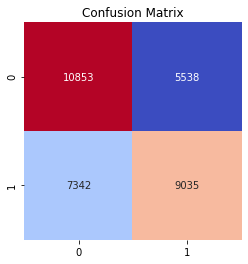

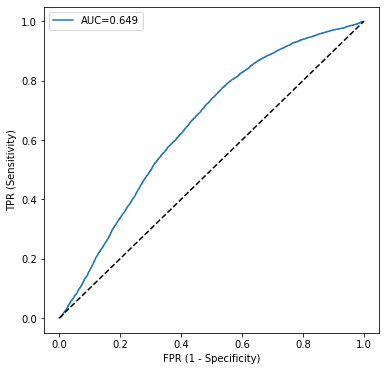

In [12]:
results_logistic = get_result_metrics(y_true=test_y, y_score=y_pred[:,1])

ax = sns.heatmap(
    results_logistic["confusion_matrix"],
    annot=True,
    cmap="coolwarm",
    cbar=False,
    square=True,
    fmt='d'
)
ax.set_title("Confusion Matrix")

plt.figure(figsize=(6,6))
plt.plot(results_logistic["fpr"], results_logistic["tpr"], label="AUC={:.3f}".format(results_logistic["auc"]))
plt.plot([0,1], [0, 1], 'k--')
plt.xlabel("FPR (1 - Specificity)")
plt.ylabel("TPR (Sensitivity)")
plt.legend()
plt.show()

In [13]:
dtrain = xgb.DMatrix(train_x_vector, label=train_y)
dvalid = xgb.DMatrix(valid_x_vector, label=valid_y)
dtest = xgb.DMatrix(test_x_vector, label=test_y)

In [14]:
params_xgb = {
    "max_depth": 6,
    "eta": 0.03,
    "objective": "binary:logistic",
    "nthread": 8,
    "eval_metric": "auc",
    "tree_method": "gpu_hist",
    "gpu_id": 5
}
eval_list = [(dvalid, 'eval'), (dtrain, 'train')]

In [15]:
model_xgb = xgb.train(
    params=params_xgb,
    dtrain=dtrain,
    num_boost_round=100,
    evals=eval_list
)

[0]	eval-auc:0.77073	train-auc:0.80220
[1]	eval-auc:0.81250	train-auc:0.84846
[2]	eval-auc:0.83212	train-auc:0.86963
[3]	eval-auc:0.84704	train-auc:0.88406
[4]	eval-auc:0.85438	train-auc:0.89419
[5]	eval-auc:0.86548	train-auc:0.90439
[6]	eval-auc:0.87126	train-auc:0.91133
[7]	eval-auc:0.87678	train-auc:0.91798
[8]	eval-auc:0.87906	train-auc:0.92014
[9]	eval-auc:0.88087	train-auc:0.92303
[10]	eval-auc:0.88358	train-auc:0.92589
[11]	eval-auc:0.88460	train-auc:0.92639
[12]	eval-auc:0.88766	train-auc:0.92934
[13]	eval-auc:0.88967	train-auc:0.93227
[14]	eval-auc:0.89157	train-auc:0.93392
[15]	eval-auc:0.89244	train-auc:0.93498
[16]	eval-auc:0.89470	train-auc:0.93656
[17]	eval-auc:0.89596	train-auc:0.93727
[18]	eval-auc:0.89796	train-auc:0.93916
[19]	eval-auc:0.89878	train-auc:0.94044
[20]	eval-auc:0.90028	train-auc:0.94183
[21]	eval-auc:0.90180	train-auc:0.94310
[22]	eval-auc:0.90319	train-auc:0.94420
[23]	eval-auc:0.90405	train-auc:0.94513
[24]	eval-auc:0.90497	train-auc:0.94613
[25]	eval-

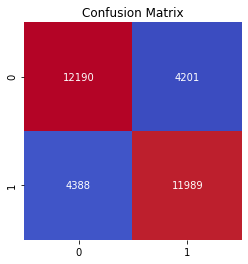

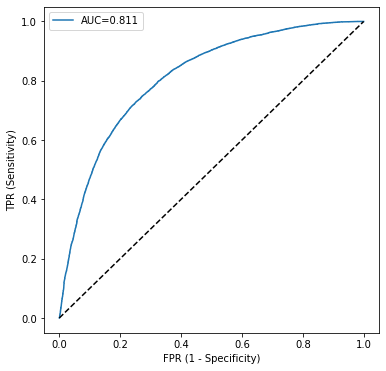

In [16]:
y_pred = model_xgb.predict(dtest)
results_xgb = get_result_metrics(y_true=test_y, y_score=y_pred)

ax = sns.heatmap(
    results_xgb["confusion_matrix"],
    annot=True,
    cmap="coolwarm",
    cbar=False,
    square=True,
    fmt='d'
)
ax.set_title("Confusion Matrix")

plt.figure(figsize=(6,6))
plt.plot(results_xgb["fpr"], results_xgb["tpr"], label="AUC={:.3f}".format(results_xgb["auc"]))
plt.plot([0,1], [0, 1], 'k--')
plt.xlabel("FPR (1 - Specificity)")
plt.ylabel("TPR (Sensitivity)")
plt.legend()
plt.show()

## Train classifer - with feature engineering

In [17]:
import cv2
from skimage.feature import hog, canny

from joblib import Parallel, delayed

def stack_features(image):
    f_hog = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1))
    f_canny = canny(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)).ravel().astype(np.float32)
    
    features = np.concatenate([f_hog, f_canny], axis=0)
    return features

# train_x_features = [stack_features(i) for i in train_x]
train_x_features = Parallel(n_jobs=8)(delayed(stack_features)(img) for img in train_x)
train_x_features = np.array(train_x_features)

valid_x_features = Parallel(n_jobs=8)(delayed(stack_features)(img) for img in valid_x)
valid_x_features = np.array(valid_x_features)

test_x_features = Parallel(n_jobs=8)(delayed(stack_features)(img) for img in test_x)
test_x_features = np.array(test_x_features)

In [18]:
dtrain = xgb.DMatrix(train_x_features, label=train_y)
dvalid = xgb.DMatrix(valid_x_features, label=valid_y)
dtest = xgb.DMatrix(test_x_features, label=test_y)

In [19]:
params_xgb = {
    "max_depth": 6,
    "eta": 0.03,
    "objective": "binary:logistic",
    "nthread": 8,
    "eval_metric": "auc",
    "tree_method": "gpu_hist",
    "gpu_id": 5
}
eval_list = [(dvalid, 'eval'), (dtrain, 'train')]

In [20]:
model_xgb = xgb.train(
    params=params_xgb,
    dtrain=dtrain,
    num_boost_round=500,
    evals=eval_list
)

[0]	eval-auc:0.64453	train-auc:0.64973
[1]	eval-auc:0.66350	train-auc:0.66872
[2]	eval-auc:0.66900	train-auc:0.67611
[3]	eval-auc:0.66907	train-auc:0.67593
[4]	eval-auc:0.67034	train-auc:0.67661
[5]	eval-auc:0.67313	train-auc:0.68087
[6]	eval-auc:0.68172	train-auc:0.68678
[7]	eval-auc:0.68450	train-auc:0.69313
[8]	eval-auc:0.69004	train-auc:0.69838
[9]	eval-auc:0.69391	train-auc:0.70119
[10]	eval-auc:0.69634	train-auc:0.70774
[11]	eval-auc:0.69724	train-auc:0.70937
[12]	eval-auc:0.69869	train-auc:0.71327
[13]	eval-auc:0.70025	train-auc:0.71365
[14]	eval-auc:0.70124	train-auc:0.71645
[15]	eval-auc:0.70178	train-auc:0.71755
[16]	eval-auc:0.70378	train-auc:0.71948
[17]	eval-auc:0.70425	train-auc:0.72083
[18]	eval-auc:0.70569	train-auc:0.72352
[19]	eval-auc:0.70847	train-auc:0.72564
[20]	eval-auc:0.71197	train-auc:0.72810
[21]	eval-auc:0.71327	train-auc:0.72832
[22]	eval-auc:0.71444	train-auc:0.73165
[23]	eval-auc:0.71545	train-auc:0.73185
[24]	eval-auc:0.71497	train-auc:0.73317
[25]	eval-

[203]	eval-auc:0.82382	train-auc:0.96067
[204]	eval-auc:0.82396	train-auc:0.96096
[205]	eval-auc:0.82425	train-auc:0.96139
[206]	eval-auc:0.82456	train-auc:0.96192
[207]	eval-auc:0.82468	train-auc:0.96227
[208]	eval-auc:0.82485	train-auc:0.96260
[209]	eval-auc:0.82472	train-auc:0.96282
[210]	eval-auc:0.82490	train-auc:0.96312
[211]	eval-auc:0.82524	train-auc:0.96370
[212]	eval-auc:0.82535	train-auc:0.96417
[213]	eval-auc:0.82569	train-auc:0.96437
[214]	eval-auc:0.82565	train-auc:0.96469
[215]	eval-auc:0.82604	train-auc:0.96519
[216]	eval-auc:0.82631	train-auc:0.96553
[217]	eval-auc:0.82634	train-auc:0.96606
[218]	eval-auc:0.82659	train-auc:0.96648
[219]	eval-auc:0.82662	train-auc:0.96690
[220]	eval-auc:0.82722	train-auc:0.96732
[221]	eval-auc:0.82730	train-auc:0.96764
[222]	eval-auc:0.82753	train-auc:0.96815
[223]	eval-auc:0.82775	train-auc:0.96834
[224]	eval-auc:0.82763	train-auc:0.96882
[225]	eval-auc:0.82788	train-auc:0.96894
[226]	eval-auc:0.82836	train-auc:0.96935
[227]	eval-auc:0

[403]	eval-auc:0.85048	train-auc:0.99760
[404]	eval-auc:0.85073	train-auc:0.99763
[405]	eval-auc:0.85096	train-auc:0.99768
[406]	eval-auc:0.85133	train-auc:0.99774
[407]	eval-auc:0.85132	train-auc:0.99780
[408]	eval-auc:0.85147	train-auc:0.99785
[409]	eval-auc:0.85169	train-auc:0.99789
[410]	eval-auc:0.85200	train-auc:0.99791
[411]	eval-auc:0.85208	train-auc:0.99792
[412]	eval-auc:0.85206	train-auc:0.99796
[413]	eval-auc:0.85216	train-auc:0.99799
[414]	eval-auc:0.85231	train-auc:0.99803
[415]	eval-auc:0.85229	train-auc:0.99804
[416]	eval-auc:0.85231	train-auc:0.99809
[417]	eval-auc:0.85221	train-auc:0.99811
[418]	eval-auc:0.85209	train-auc:0.99814
[419]	eval-auc:0.85201	train-auc:0.99818
[420]	eval-auc:0.85221	train-auc:0.99822
[421]	eval-auc:0.85252	train-auc:0.99825
[422]	eval-auc:0.85262	train-auc:0.99830
[423]	eval-auc:0.85276	train-auc:0.99834
[424]	eval-auc:0.85281	train-auc:0.99837
[425]	eval-auc:0.85284	train-auc:0.99838
[426]	eval-auc:0.85304	train-auc:0.99841
[427]	eval-auc:0

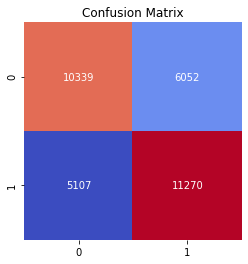

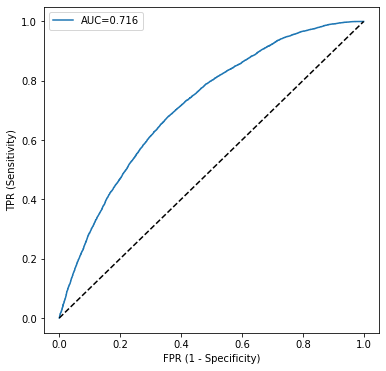

In [21]:
y_pred = model_xgb.predict(dtest)
results_xgb = get_result_metrics(y_true=test_y, y_score=y_pred)

ax = sns.heatmap(
    results_xgb["confusion_matrix"],
    annot=True,
    cmap="coolwarm",
    cbar=False,
    square=True,
    fmt='d'
)
ax.set_title("Confusion Matrix")

plt.figure(figsize=(6,6))
plt.plot(results_xgb["fpr"], results_xgb["tpr"], label="AUC={:.3f}".format(results_xgb["auc"]))
plt.plot([0,1], [0, 1], 'k--')
plt.xlabel("FPR (1 - Specificity)")
plt.ylabel("TPR (Sensitivity)")
plt.legend()
plt.show()